In [1]:
num_qubits_list = [7]
num_trial = 1

In [2]:
from qiskit_aer import AerSimulator
from qiskit import Aer
from qiskit import transpile

In [3]:
def change_bin(bit_list) :
    value = 0
    for element in bit_list[::-1]:
        value = value*2
        value += element
    return value


def generate_binaries(n):

    L=[[] for j in range(n)]


    for i in range(pow(2,n-1)) :
        ca = list(bin(i))[2:]
        for j in range(len(ca)) :
            ca[j] = int(ca[j])
        if len(ca) < n-1 :
            ca = [0 for k in range(n - 1 - len(ca))] + ca

        num_one = 0
        for i in range(0,n-1):
            if ca[i] == 1:
                num_one += 1

        #print(num_one)
        num_anc = n-1
        if num_one < n/2:
            for i in range(0,n-1):
                if ca[i] == 1:
                    L[i+1].append(change_bin(ca))
        else: 
            L[0].append(change_bin(ca))
            for i in range(0,n-1):
                if ca[i] == 0:
                    L[i+1].append(change_bin(ca)) 
    return L

In [10]:
import qiskit.quantum_info as qi

x_op = qi.Operator([[0,1],[1,0]])

In [11]:
from qiskit_aer.noise import NoiseModel, pauli_error

In [12]:
p_err = 0.03 # 0.25 # 0.1 # 0. 

error_inv_x = pauli_error([('X', 1 - p_err), ('I', p_err)])

In [13]:
noise_model = NoiseModel()

# noise_model.add_all_qubit_quantum_error(error_x, 'bit-flip')
noise_model.add_all_qubit_quantum_error(error_inv_x, 'bit-flip')

noise_model.add_basis_gates(['unitary'])

# noise_model.add_quantum_error(error_x, 'x', [1])

In [14]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
import numpy as np
from qiskit_aer.noise import pauli_error
from tqdm import tqdm

def string_1s(n):
    ssss = '1'
    for i in range(n-1):
        ssss+='1'
    return ssss

def string_0s(n):
    ssss = '0'
    for i in range(n-1):
        ssss+='0'
    return ssss

def return_to_bits(bit_string) :
    b = int(bit_string,2)
    return b

error_type = 'bit-flip' # 'phase-flip'

counts_list_list = []
for n in num_qubits_list:
    
    ##### number of qubits #####

    ##### number of shots #####
    shots_num = 10000

    ##### circuit setting ######
    q0 = QuantumRegister(n, 'qm') # message
    q1 = QuantumRegister(n-1, 'qa') # ancillar
    c0 = ClassicalRegister(n, 'cm')
    c1 = ClassicalRegister(n-1, 'ca')
    circuit = QuantumCircuit(q0, q1, c0, c1)

    ##### encoding a physical qubit into a logical qubit #####
    for i in range(1,n):
        circuit.cx(q0[0],q0[i])
        
    ##### convert phase flip into bit flip #####
    if error_type == 'phase-flip':
        circuit.h(q0)
    circuit.barrier(q0, q1)
    
    ##### introduce errors #####
    if error_type == 'phase-flip':
        circuit.z(q0[0])
        circuit.z(q0[1])
    elif error_type == 'bit-flip':
        circuit.unitary(x_op, q0, label='bit-flip')
    circuit.barrier(q0, q1)
    
    ##### convert phase flip into bit flip #####
    if error_type == 'phase-flip':
        circuit.h(q0)
    
    ##### make ancilla qubits #####
    for i in range(0, n-1):
        circuit.cx(q0[0], q1[i])
        circuit.cx(q0[i+1], q1[i])
    circuit.barrier(q0, q1)
    

    ##### measure ancillas #####
    circuit.measure(q1,c1)
    circuit.barrier(q0,q1)

    ##### correction circuit #####
    num_list_list = generate_binaries(n)
    for j_qubit, num_list in enumerate(num_list_list):
        for num in num_list:
            circuit.x(q0[j_qubit]).c_if(c1,num)
            
#     for num in [0b1111,0b1110,0b1101,0b1011,0b0110]:
#         circuit.x(q0[0]).c_if(c1,num)
#     for num in []:
#         circuit.x(q0[1]).c_if(c1,num)

#     p = 2**(n-1)
#     circuit.x(q0[0]).c_if(c1,2**(n-1)-1)
#     for i in range(0, n-1):
#         circuit.x(q0[i+1]).if(c1,2**(i))
        
#         circuit.x(q0[i+1]).c_if(c1,2**(n-2-i))
#     circuit.x(q0[2]).c_if(c1[2],1)

    circuit.barrier(q0,q1)
    ##### result measurement #####
    circuit.measure(q0,c0)

    ##################################################
#     from qiskit import Aer, execute
    
#     backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

#     from qiskit.providers.fake_provider  import FakeMumbai
#     backend = FakeMumbai()

#     backend = AerSimulator()
    backend = AerSimulator(noise_model=noise_model)
    tcirc = transpile(circuit, backend)

    ##################################################

    n_data = []
    counts_list = []
    for iteration_number in tqdm(range(num_trial)):
        
        iteration_data = []
        
        string_0 = string_0s(n)
        string_1 = string_1s(n)
        
#         job = execute(tcirc, backend, shots=shots_num)
        job = backend.run(tcirc, shots=shots_num)
        result = job.result()
        counts = result.get_counts(tcirc)
        
        counts_list.append(counts)
        print(f"n={n}: {counts}")
    
    counts_list_list.append(counts_list)

#         bit_total_result = list(counts.keys())
#         num_000 = 0
#         for bits in bit_total_result :
#             if bits.split()[1] == string_0 :
#                 num_000 += counts[bits]
#         print("Measured number of outcome '" + string_0 + "':", num_000)

#         num_111 = 0
#         for bits in bit_total_result :
#             if bits.split()[1] == string_1 :
#                 num_111 += counts[bits]
#         print("Measured number of outcome '" + string_1 + "':", num_111)
            
#         ########    
        
#         num_eff000 = 0
#         for bits in bit_total_result :
#             if bin(return_to_bits(bits.split()[1]) ^ return_to_bits(string_0))[2:].count('1') < (n+1)/2 :
#             #if bits.split()[1] == '000' or bits.split()[1] == '001' or bits.split()[1] == '010' or bits.split()[1] == '100' :
#                 num_eff000 += counts[bits]
#         print("Measured number of outcome considered as '" + string_0 + "':", num_eff000)

#         num_eff111 = 0
#         for bits in bit_total_result :
#             if bin(return_to_bits(bits.split()[1]) ^ return_to_bits(string_1))[2:].count('1') < (n+1)/2 :
#             #if bits.split()[1] == '111' or bits.split()[1] == '110' or bits.split()[1] == '101' or bits.split()[1] == '011' :
#                 num_eff111 += counts[bits]
#         print("Measured number of outcome considered as '" + string_1 + "':", num_eff111)
        
#         ########
        
#         iteration_data.append([num_000, num_111, num_eff000, num_eff111])
#         n_data.append(iteration_data)
        
#     np.save(str(n) + "_qubits.npy", np.array(n_data))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:17<00:00, 77.96s/it]

n=7: {'010000 0000000': 254, '000000 0000000': 8033, '001000 0000000': 236, '000100 0000000': 256, '000001 0000000': 251, '000010 0000000': 255, '010101 0000000': 1, '100000 0000000': 266, '111111 0000000': 275, '101111 0000000': 9, '000101 0000000': 10, '010001 0000000': 12, '100010 0000000': 13, '010010 0000000': 8, '000011 0000000': 9, '001001 0000000': 6, '011111 0000000': 7, '100100 0000000': 7, '001100 0000000': 9, '111110 0000000': 6, '000110 0000000': 11, '110101 0000000': 1, '010100 0000000': 4, '100001 0000000': 6, '110000 0000000': 7, '011000 0000000': 6, '110111 0000000': 7, '001111 0000000': 1, '111101 0000000': 5, '111000 0000000': 1, '101000 0000000': 10, '111011 0000000': 5, '001010 0000000': 7, '010110 0000000': 1, '111100 0000000': 1, '000111 0000000': 1, '001101 0000000': 1, '110001 0000000': 1, '100111 0000000': 1}


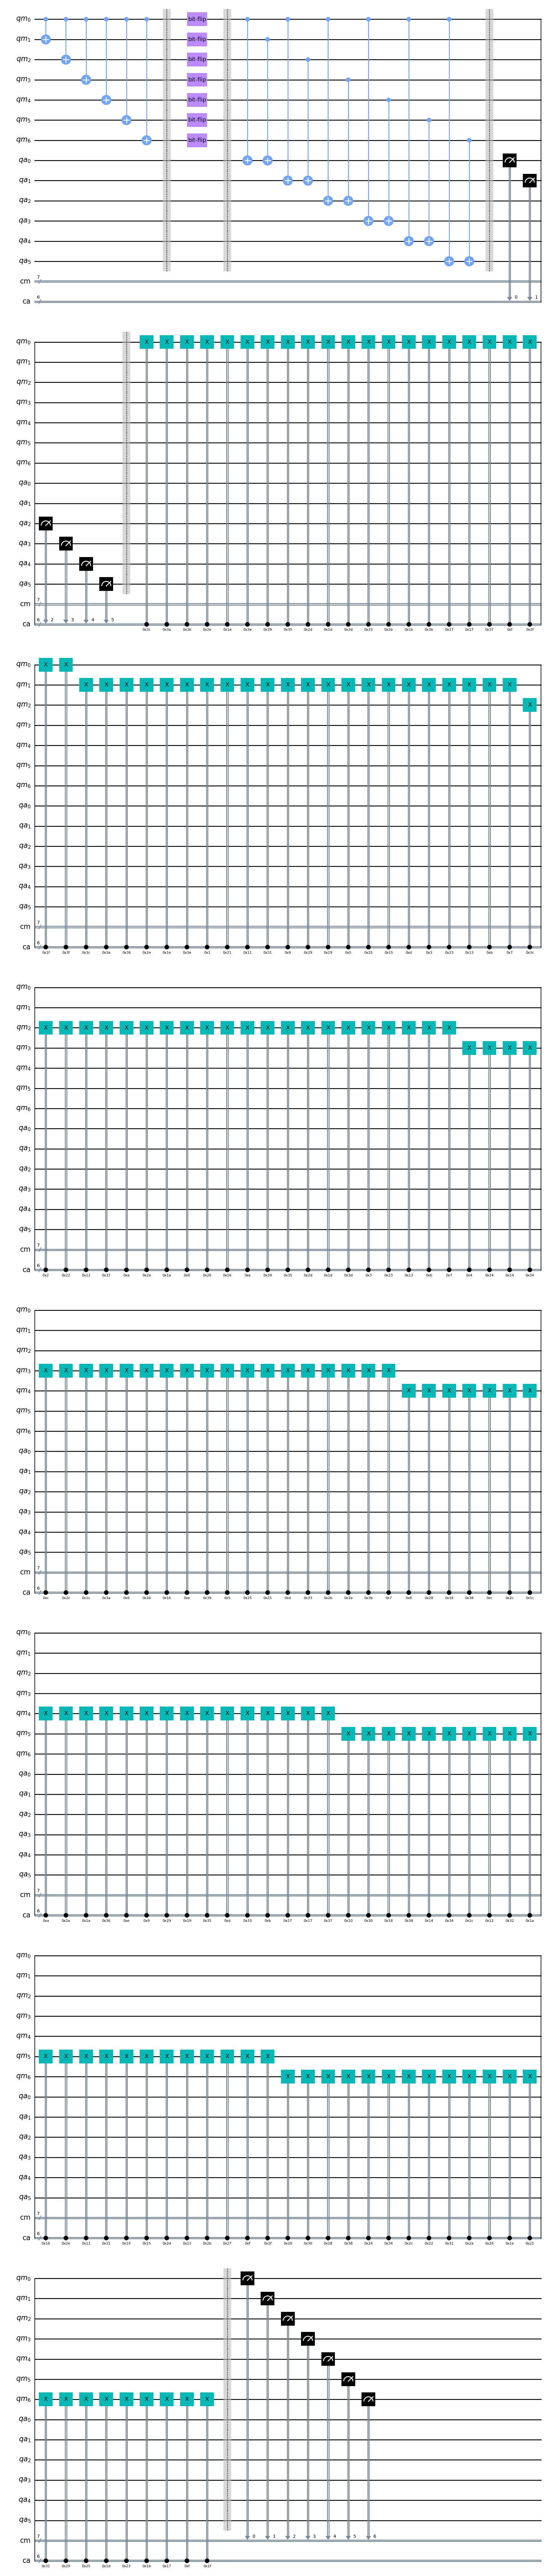

In [15]:
# circuit.draw('mpl', filename='circuit-test-001.png')

In [18]:
counts = counts_list_list[0][0]

In [19]:
data_list = set([k.split()[-1] for k in counts.keys()])

In [20]:
nq = num_qubits_list[0]

all_0 = '0' * nq
all_1 = '1' * nq
counts_data = {all_0:0, all_1:0}
for k, v in counts.items():
    if k[-nq:] == all_0:
        counts_data[all_0] += v
    else:
        counts_data[all_1] += v

In [22]:
counts_data

{'0000000': 10000, '1111111': 0}

In [23]:
from qiskit.visualization import plot_histogram

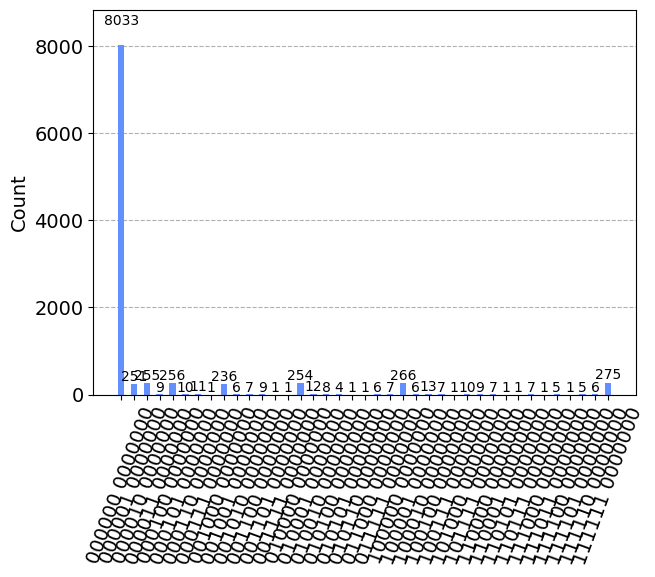

In [24]:
plot_histogram(counts_list_list[0][0])

In [173]:
tcirc.draw()

░ ┌──────────┐ ░                                    »
qm_0: ──■────■────■────■───░─┤ bit-flip ├─░───■────■─────────■─────────■───────»
      ┌─┴─┐  │    │    │   ░ ├──────────┤ ░   │    │         │         │       »
qm_1: ┤ X ├──┼────┼────┼───░─┤ bit-flip ├─░───┼────┼────■────┼─────────┼───────»
      └───┘┌─┴─┐  │    │   ░ ├──────────┤ ░   │    │    │    │         │       »
qm_2: ─────┤ X ├──┼────┼───░─┤ bit-flip ├─░───┼────┼────┼────┼────■────┼───────»
           └───┘┌─┴─┐  │   ░ ├──────────┤ ░   │    │    │    │    │    │       »
qm_3: ──────────┤ X ├──┼───░─┤ bit-flip ├─░───┼────┼────┼────┼────┼────┼────■──»
                └───┘┌─┴─┐ ░ ├──────────┤ ░   │    │    │    │    │    │    │  »
qm_4: ───────────────┤ X ├─░─┤ bit-flip ├─░───┼────┼────┼────┼────┼────┼────┼──»
                     └───┘ ░ └──────────┘ ░ ┌─┴─┐  │  ┌─┴─┐  │    │    │    │  »
qa_0: ─────────────────────░──────────────░─┤ X ├──┼──┤ X ├──┼────┼────┼────┼──»
                           ░              ░ └───┘┌─┴─┐└───┘  │  ┌─┴─┐  │    │  »
qa_1: ─────────────────────░──────────────░──────┤ X ├───────┼──┤ X ├──┼────┼──»
                           ░              ░      └───┘     ┌─┴─┐└───┘  │  ┌─┴─┐»
qa_2: ─────────────────────░──────────────░────────────────┤ X ├───────┼──┤ X ├»
                           ░              ░                └───┘     ┌─┴─┐└───┘»
qa_3: ─────────────────────░──────────────░──────────────────────────┤ X ├─────»
                           ░              ░                          └───┘     »
cm: 5/═════════════════════════════════════════════════════════════════════════»
                                                                               »
ca: 4/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«            ░              ░  ┌───┐  ┌───┐  ┌───┐  ┌───┐  ┌───┐               »
«qm_0: ──────░──────────────░──┤ X ├──┤ X ├──┤ X ├──┤ X ├──┤ X ├───────────────»
«            ░              ░  └─╥─┘  └─╥─┘  └─╥─┘  └─╥─┘  └─╥─┘  ┌───┐  ┌───┐ »
«qm_1: ──────░──────────────░────╫──────╫──────╫──────╫──────╫────┤ X ├──┤ X ├─»
«            ░              ░    ║      ║      ║      ║      ║    └─╥─┘  └─╥─┘ »
«qm_2: ──────░──────────────░────╫──────╫──────╫──────╫──────╫──────╫──────╫───»
«            ░              ░    ║      ║      ║      ║      ║      ║      ║   »
«qm_3: ──────░──────────────░────╫──────╫──────╫──────╫──────╫──────╫──────╫───»
«            ░              ░    ║      ║      ║      ║      ║      ║      ║   »
«qm_4: ──■───░──────────────░────╫──────╫──────╫──────╫──────╫──────╫──────╫───»
«        │   ░ ┌─┐          ░    ║      ║      ║      ║      ║      ║      ║   »
«qa_0: ──┼───░─┤M├──────────░────╫──────╫──────╫──────╫──────╫──────╫──────╫───»
«        │   ░ └╥┘┌─┐       ░    ║      ║      ║      ║      ║      ║      ║   »
«qa_1: ──┼───░──╫─┤M├───────░────╫──────╫──────╫──────╫──────╫──────╫──────╫───»
«        │   ░  ║ └╥┘┌─┐    ░    ║      ║      ║      ║      ║      ║      ║   »
«qa_2: ──┼───░──╫──╫─┤M├────░────╫──────╫──────╫──────╫──────╫──────╫──────╫───»
«      ┌─┴─┐ ░  ║  ║ └╥┘┌─┐ ░    ║      ║      ║      ║      ║      ║      ║   »
«qa_3: ┤ X ├─░──╫──╫──╫─┤M├─░────╫──────╫──────╫──────╫──────╫──────╫──────╫───»
«      └───┘ ░  ║  ║  ║ └╥┘ ░    ║      ║      ║      ║      ║      ║      ║   »
«cm: 5/═════════╬══╬══╬══╬═══════╬══════╬══════╬══════╬══════╬══════╬══════╬═══»
«               ║  ║  ║  ║    ┌──╨──┐┌──╨──┐┌──╨──┐┌──╨──┐┌──╨──┐┌──╨──┐┌──╨──┐»
«ca: 4/═════════╩══╩══╩══╩════╡ 0xf ╞╡ 0xe ╞╡ 0xd ╞╡ 0xb ╞╡ 0x7 ╞╡ 0x1 ╞╡ 0xe ╞»
«               0  1  2  3    └─────┘└─────┘└─────┘└─────┘└─────┘└─────┘└─────┘»
«                                                                            »
«qm_0: ──────────────────────────────────────────────────────────────────────»
«       ┌───┐  ┌───┐  ┌───┐                                                  »
«qm_1: ─┤ X ├──┤ X ├──┤ X ├─────────────────────────────────────